# Efficient Emulation of SECAR Beam
Contributed by: Diógenes Figueroa
Edited by: Pablo Giuliani


This section is based on a final project for the [FRIB-TA Summer School: Practical Uncertainty Quantification and Emulator Development in Nuclear Physics](https://indico.frib.msu.edu/event/65/), all code shown here are simplified versions of the publicly final project repository available here: [RBM SECAR](https://github.com/diogenes1991/RBMSecar)

In this section we discuss how to apply the reduced basis method to problems for which the underlying dynamics are unknown or complicated enough that tracking the dependence on the parametrs of interest is unfeasible. We will explore two kinds of emulators:

- **Interpolation Emulators**: For these kinds of emulators the idea is to use the information obtained from the high-fidelity solver to build interpolators for the coefficients of the principal components.
- **BlackBox Emulators**: For these kind of emulators we try to find some effective dynamics for our problem and build the equivalent of the Galerkin projection equations for those.

In [1]:
import time, os
import math, array, random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.interpolate import CubicSpline

## Interpolation Emulator for SECAR

The problem that we are trying to tackle here is the emulation of beam dynamics for the [SECAR](http://secar.space/) experiment, as discussed at the introduction of this book. These dynamics are governed by the interactions between the charged particles in the beams and the magnetic fields generated by each one of the 19 electromagnets of the experiment. Each one of these magnets influences the trajectory of the beams, an effect which we can parametrize as a power series on the characteristics of the beam is employed. For simplicity we shall parametrize the state of the electromagnets as one-dimensional, depending only on the current $I$ flowing through it. Symbolically, if we denote by $v$ the state of the beam, the transport equation looks like:

\begin{equation}
    v^{after}_i = (S^0[I])_i + (S^1[I])_i{}^jv^{before}_j + (S^2[I])_i{}^{jk}v^{before}_jv^{before}_k+\cdots 
\end{equation}

In the case of SECAR, the tensors $S^0,S^1,\cdots$ (i.e. the high-fidelity solutions) are calculated by the [COSY INFINITY](https://www.bmtdynamics.org/index_cosy.htm) system. This program is capable of finding these transport tensors for any order. In the application we show here the COSY program has been used to generate $100$ high-fidelity solutions for the transport of beams described by $8$ state variables. Tensors of degree up to $4$ are kept. 

Our reduced basis approximation will read:

\begin{equation}
    S^{l} (I) \approx \hat S^{l} (I) = \sum_{k=1}^n a_k^l(I) S_k^{l},
\end{equation}

for every tensor $S^{l}$ $(l=0,1,\cdots)$. Now, the dependence on the current is carried by the coefficients $a_k^l(I)$

### Some helpers for reading COSY files

In [2]:
from itertools import combinations_with_replacement

def generate_lookup(**kwargs):
    
    low_pow = kwargs["lowPower"]
    hig_pow = kwargs["highPower"]
    num_let = kwargs["nLetters"]
    
    ''' Generate all nLetters words '''
    letters = [ chr(i) for i in range(num_let) ]
    words = []
    for r in range(low_pow, hig_pow+1):
        combinations_list = combinations_with_replacement(letters, r)
        words.extend([''.join(combo) for combo in combinations_list])
    
    ''' Convert from words to a lookup table '''
    word_to_list = lambda word       : [  str(word.count(letter)) for letter in letters ]
    list_to_key  = lambda base,array : list_to_key(base+array[0],array[1:]) if len(array) else base
    word_to_key  = lambda word       : list_to_key('',word_to_list(word))
    
    ''' Lookup table '''
    lookup   = dict( [ (word_to_key(words[i]),i) for i in range(len(words)) ] )
    
    return lookup

class CosyIO:
    
    '''  
        COSY Formatted files reader class
    
    '''
    
    def __init__(self,nLetters=8,lowPower=0,highPower=4):
        self.nLetters  = nLetters
        self.lowPower  = lowPower
        self.higiPower = highPower
        
        ''' We generate a static lookup table to synchronize all matrices '''
        self.lookup = generate_lookup(lowPower=lowPower,highPower=highPower,nLetters=nLetters)
        self.inverse  = dict( [(self.lookup[key],key) for key in self.lookup] )
        
        ''' Convert keys to list of powers '''
        self.key_to_list = lambda k,l : self.key_to_list(k[1:],l+[int(k[0])]) if len(k)!=0 else l
        
    def read(self,path):
        file = open(path,"r")
        self.matrices = []
        local_mat = np.zeros(len(self.lookup.keys()))
        count = 1
        for line in file:
            count += 1
            vec = line.split()
            
            ''' Save specifications '''
            if vec[0] == "L":
                self.L = float(vec[1])
                continue
            if vec[0] == "P":
                self.P = [float(v[:-1]) for v in vec[2:]]
                continue
            if vec[0] == "A":
                self.A = [float(v[:-1]) for v in vec[2:]]
                continue
                
            ''' Skip Matrix header '''
            if vec[0] == "I":
                self.header = line
                continue
            
            ''' Append at the end of matrix character '''
            if vec[0][0] == "-":
                self.footer = line
                self.matrices.append(local_mat)
                local_mat = np.zeros(len(self.lookup.keys()))
            
            else:
                ''' Build the key to lookup '''
                word = ""
                for i in range(3,len(vec)):
                    word+=vec[i]
                    
                try:
                    local_mat[self.lookup[word]] = float(vec[1])
                except:
                    print(word,count)
        file.close()

In [3]:
class Emulator:
    
    ''' 
        Interpolation-Based Emulator 
        Uses Cubic Splines to interpolate the 
        principal components' coefficients 
    
    '''
    
    def __init__(self,axis,matrix,cutoff):
        self.axis   = axis
        self.matrix = matrix
        self.cutoff = cutoff
        self.height,self.width = self.matrix.shape
        self.build()
    
    def normalize(self):
        ''' Normalize the data '''
        self.means = [ np.average(self.matrix[:,i]) for i in range(self.width) ]
        self.sdevs = [ np.std(self.matrix[:,i])     for i in range(self.width) ]
        self.renor = [ [
                                ( self.matrix[i][j]-self.means[j] )/self.sdevs[j] 
                            if self.sdevs[j] != 0 else 0 
                        for j in range(self.width) ] 
                      for i in range(self.height) ]
        self.renor = np.array(self.renor)
    
    def build(self):
        ''' Build all the CubicSpline interpolators '''
        self.normalize()
        
        ''' Find the Principal Components '''
        self.u,self.s,self.v = np.linalg.svd(self.renor)
        
        ''' Build all the CubicSpline interpolators for the coefficients '''
        self.splines = [ sp.interpolate.CubicSpline(self.axis,self.u[:,i]) for i in range(self.cutoff) ]
    
    def __call__(self,value):
        rval = np.zeros(self.width)
        for i in range(self.cutoff):
            rval += self.splines[i](value)*self.s[i]*self.v[i]
        rval = np.multiply(rval,self.sdevs) + self.means
        return rval

In [4]:
class CosyMagnet(Emulator):
    
    ''' Wrapped emulator for the Cosy format '''
    
    def __init__(self,**kwargs):
        
        ''' Load all the datafile names and assume the scale is the name  '''
        self.path   = kwargs["path"]
        self.data   = os.listdir(self.path)
        self.data.sort(key=lambda item : float(item))
        scales      = [ float(name) for name in self.data ]
        
        ''' Format the flattened data matrix, file = row '''
        matrix = []
        
        self.cosyIO = CosyIO()
        for i in range(len(self.data)):
            ''' 
                Here we should save the magnet specs and complain if 
                some magnets do not have the same specs
            '''
            self.cosyIO.read(os.path.join(self.path,self.data[i]))
            
            ''' Flatten the matrices '''
            big_row = []
            for mat in self.cosyIO.matrices:
                for row in mat:
                    big_row.append(row)
            matrix.append(big_row)
        matrix = np.array(matrix)
        
        ''' Emulator build '''
        self.cutoff = kwargs["cutoff"]
        super().__init__(scales,matrix,self.cutoff)

**Now we can start importing high-fidelity solutions and trian some emulators**

First we train $7$ emulators using the test data

In [5]:
path_to_magnet = "MagnetData/Q1/train"
nEmulators     = 7
Emulators      = [ CosyMagnet(path=path_to_magnet,cutoff=(3*i+3)) for i in range(nEmulators) ]

Now let's see the actual data and see how the singular components decay. These components will be our reduced basis $S^l_k$.

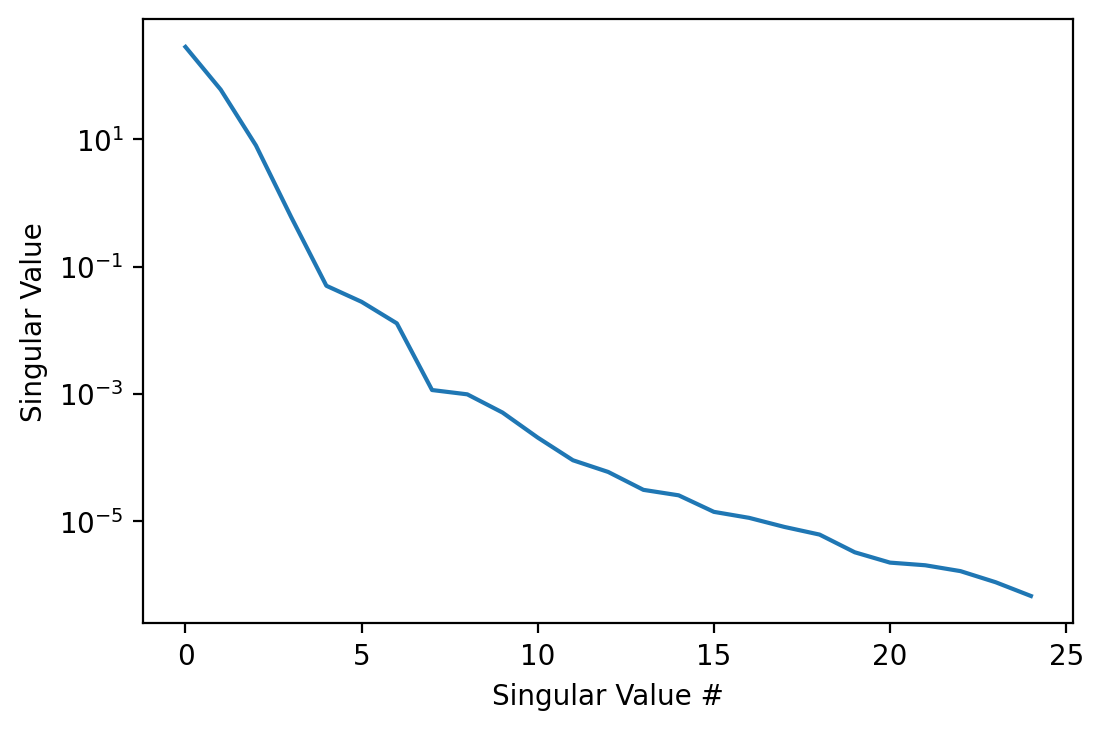

In [6]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor("white")
ax.semilogy(Emulators[0].s[:25])
plt.xlabel("Singular Value #")
plt.ylabel("Singular Value")
plt.show()

This tells us that by keeping 5-10 singular values we would capture most of the dynamics.
Since we are also interpolating the coefficients $a_k^l(I)$ it might be a good idea to look at them, since if they are not smooth enough we might get bad results

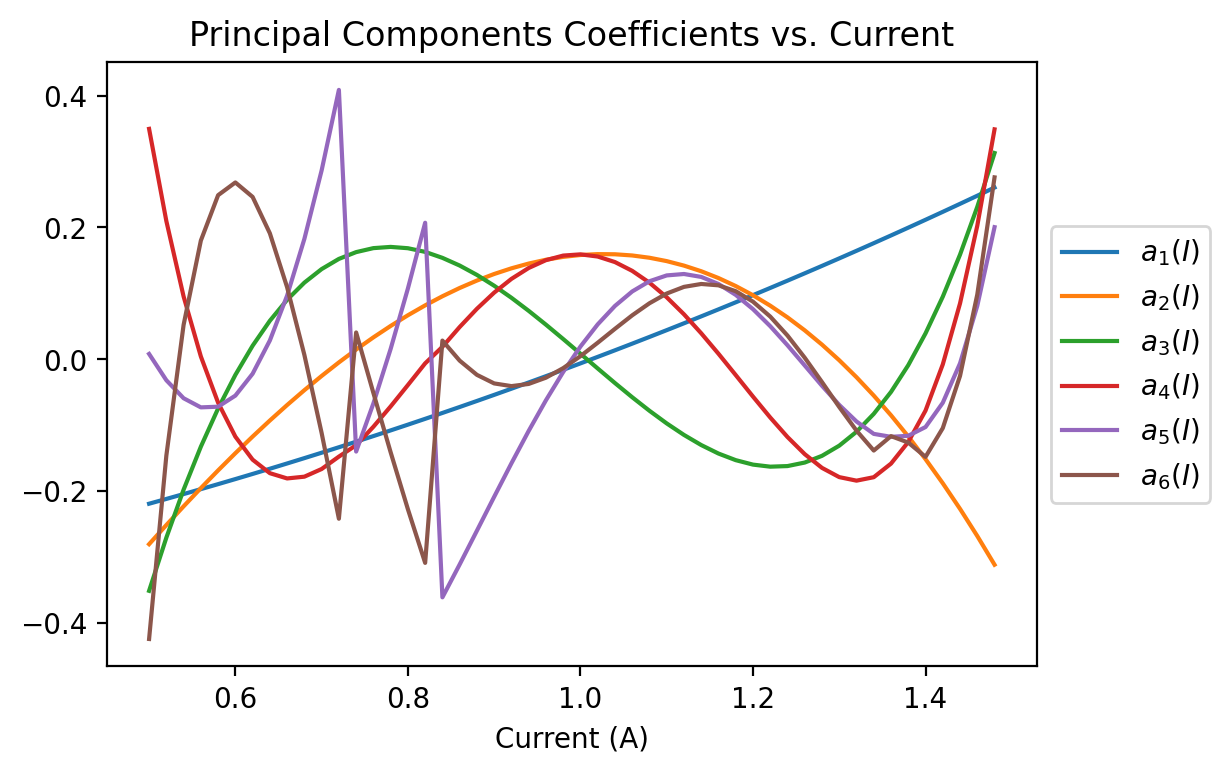

In [7]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor("white")
for i in range(6):
    ax.plot(Emulators[0].axis,Emulators[0].u[:,i],label=r"$a_{}(I)$".format(i+1))

plt.title("Principal Components Coefficients vs. Current")
plt.xlabel("Current (A)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We see that most of them are pretty smooth, but the discontinuities on the smaller pcs might prevent us from reaching really small errors.

**Accuarcy of the emulatiors**

For this we use dummy CosyMagnet instance to load the test dataset into python

In [8]:
test_Magnet = CosyMagnet(path="MagnetData/Q1/test",cutoff=1)
scales   = test_Magnet.axis
matrices = test_Magnet.matrix

In [9]:
def error(emulated,real):
    return np.sqrt(np.sum(np.square(emulated - real))/np.sum(np.square(real)))

error_matrix   = [ [ error(Emulators[i](scales[j]),matrices[j]) for j in range(len(scales)) ] for i in range(nEmulators) ]

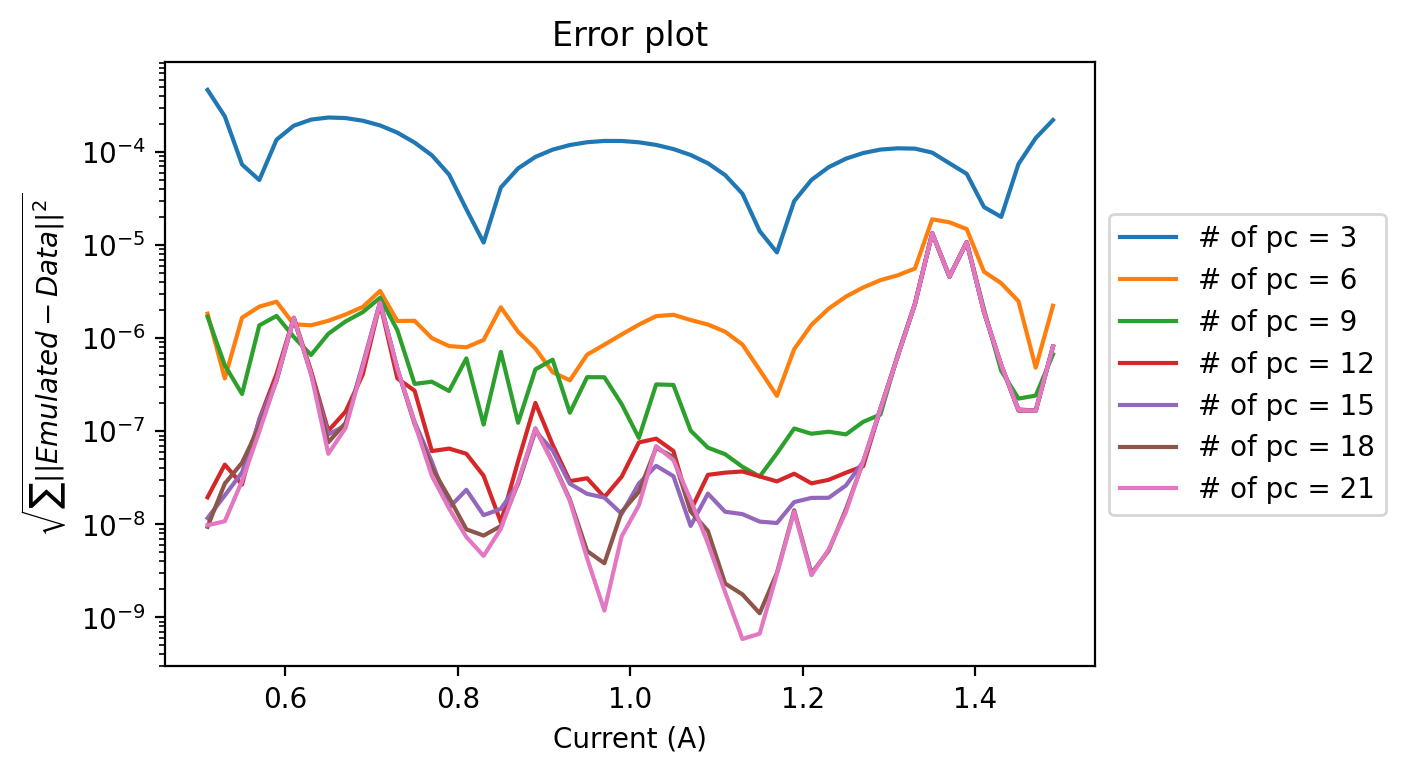

In [10]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor("white")
for i in range(nEmulators):
    ax.semilogy(scales,error_matrix[i],label="# of pc = "+str(Emulators[i].cutoff))
plt.xlabel("Current (A)")
plt.ylabel(r"$\sqrt{\sum ||Emulated - Data||^2}$")
plt.title("Error plot")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Here we notice that the error becomes worse near the places of discontinuity of the original coefficients. We could use these emulators to evaluate beam transport, see: [RBM SECAR](https://github.com/diogenes1991/RBMSecar/blob/master/Emulator/RBM.ipynb) for more details. One way to improve on this issue would be to build effective dynamical equations for our system, as we show next.

## Black-Box Emulator for SECAR

### We now try a new approach which more closely resembles the Galerkin approach to RBM's.

The main issue is that although we have the PCs there is no defining equation $F_\alpha[\phi]=0 $ to project, $\alpha$ now taking the role of the current and $\phi$ the role of the tensors $S^l$. Lacking access to these equations is what motivated us to interpolate the reduced coefficients $a_k(I)$. 

Inspired by how for some of the previous systems we have studied in this book the dynamical equations reduced to an effective Hamiltonian, we now try to find some such a reduced operator for our problem. In this formulation we interpret the projection of the COSY matrix onto the principal components as a wavefunction and encode our problem into an eigenvalue-eigenvector problem, more precisely:

$\mathcal{H}_{\text{Eff}}(x;I) \Psi(x;I) = E\Psi(x;I) $

The problem being that the COSY matrices are not wavefunctions and thus their magnitude is important, but the eigenvalue problem is defined modulo multiplication by any non-zero factor $K(I)$, constant over $x$. We can fix this gauge in many ways for example by adding a $G(I)$ function as a new component to be emulated, upon emulation we look at the value of this channel and since we know the value it should have we know the scale factor needed for the system to be correct.

We employ a polynomial model for the hamiltonians:

$\mathcal{H}_{Eff} = \sum_{s=0}^{\infty} \mathcal{H}_{s} I^s$

for some matrices $\mathcal{H}_{s}\in M(m\times m)$ where $m$ is the number of principal components we wish to model.

**We sart with some definitions**

In [11]:
import scipy.optimize as op

def build_pdm(coefficients,n,parity=1):
    ''' Builds a parity defined matrix '''
    matrix = [[0] * n for _ in range(n)]  # Initialize matrix with zeros
    cc=0
    for i in range(n):
        for j in range(n):
            if ( j<=i if parity==-1 else j<i) :
                continue
            coefficient = coefficients[cc]  # Correct indexing
            matrix[i][j] = coefficient
            matrix[j][i] = parity*coefficient
            cc+=1
    matrix = np.array(matrix)
    return matrix

class Hamiltonian:
    
    ''' 
        Implements eigenvalue-eigenvector porblem fitter
    
    '''
    
    def __init__(self,**kwargs):
        self.axis              = kwargs["axis"]
        self.data              = kwargs["data"]
        self.width,self.height = self.data.shape
        self.u,self.s,self.v   = np.linalg.svd(self.data)
     
    ''' Enforce Eigenvectors '''
    def objective(self,variables):
        rval = 0
            
        ''' Build H0, H1, ... '''
        self.hs = [ self.matrix_method(variables[i*self.numEntries:(i+1)*self.numEntries],self.dim) for i in range(self.ord) ]
        for i,vec in enumerate(self.low_dim_rep):
                
            ''' Loop over orders '''
            self.H = np.zeros((self.dim,self.dim),self.type)
            for j in range(self.ord):
                self.H += (self.axis[i]**j)*self.hs[j]
            
            ''' Compute Eigenvectors and add residue as difference '''
            evl,evc = np.linalg.eigh(self.H)
            rval += np.linalg.norm( evc.T[0]*np.sign(evc.T[0][0]) - vec*np.sign(vec[0]) )
         
        return rval
         
    def build(self,dimension,order):
        
        ''' Here we build an approximate to the Galerkin Equations '''
        self.dim = dimension
        self.ord = order
        
        ''' First we project every datapoint onto the first dim principal components '''
        self.low_dim_rep = np.array([ [ np.dot(self.u[:,i],self.data[:,j]) for i in range(self.dim) ] for j in range(self.height) ])
        
        ''' Normalize once '''
        for i in range(len(self.low_dim_rep)):
            self.low_dim_rep[i] = self.low_dim_rep[i]/np.linalg.norm(self.low_dim_rep[i])
        
        ''' Setup a minimization problem '''
        self.numEntries = self.matrix_dimension(self.dim)
        self.vars       = np.array( [ 2*random.random()-1 for i in range(self.ord*self.numEntries)] )
        
        ''' Minimization call '''
        self.op_solution = op.minimize(self.objective,self.vars)
        self.minimum = self.op_solution['x']
    
    def predict_pcs(self,alpha):
        H = np.zeros((self.dim,self.dim),self.type)
        for j in range(self.ord):
            H += (alpha**j)*self.hs[j]
        return np.linalg.eigh(H)
    
    def predict_real(self,alpha):
        NotImplemented
        
    def test(self):
        NotImplemented
    
    def get_error(self):
        NotImplemented   

class RealHamiltonian(Hamiltonian):
    
    def __init__(self,**kwargs):
        self.matrix_dimension = lambda dim : int(dim*(dim+1)/2)
        self.type             = np.float64
        self.matrix_method    = build_pdm
        super().__init__(**kwargs)
    
    def predict_real(self,alpha):
        evl,evc = self.predict_pcs(alpha)
        rval    = np.zeros(self.width)
            
        ''' Loop over principal components '''
        for j in range(self.dim):
            rval += evc.T[0][j]*self.u[:,j]
            
        return rval
    
    def test(self):
        ''' Loop over eigenfunctions '''
        for index in range(self.dim):
            ''' Loop over known scales '''
            for scale in self.axis:
                evl,evc = self.predict_pcs(scale)
                rval    = np.zeros(self.width)
                
                ''' Loop over principal components '''
                for i in range(self.dim):
                    rval += evc.T[index][i]*self.u[:,i]
                
                ''' Plot normalized wavefunctions '''
                rval = rval / np.linalg.norm(rval)
                plt.plot(rval)
            
            plt.show()
            
    def get_error(self):
        error = []
        ''' Loop over known scales '''
        for i,scale in enumerate(self.axis):
            
            evl,evc = self.predict(scale)
            rval    = np.zeros(self.width)
            
            ''' Loop over principal components '''
            for j in range(self.dim):
                rval += evc.T[0][j]*self.u[:,j]
            
            ''' Plot normalized wavefunctions '''
            rval = rval / np.linalg.norm(rval)
            
            ''' Sign at the center '''
            s = np.sign(rval[int(len(rval)/2)])
            
            ''' Why did we transpose the data again? '''
            error.append(np.linalg.norm(s*rval - self.data[:,i]))
        
        return error


**Again we satrt by using a CosyMagnet to imput data**

We also normalize the data as if it is a wavefunction, this is to avoid the normalization issue we just discussed. Though a real implementation would need to have a way to extract the norm using some gauging function $G(I)$.

In [12]:
''' CosyMagnet to flatten the data '''
emulator = CosyMagnet(path="MagnetData/Q1/train",cutoff=1)

''' We normalize '''
data = emulator.matrix
data = np.array([ ( v/np.linalg.norm(v) if np.linalg.norm(v)!=0 else v ) for v in data]).T

Let's create a Hamiltonian finder object, here dimension refers to the number of principal components to be included on the Hamiltonian model.

In [13]:
hamiltonian = RealHamiltonian(axis=[xs for xs in emulator.axis],data=emulator.matrix.T)

dimension = 4
order     = 3
hamiltonian.build(dimension,order)

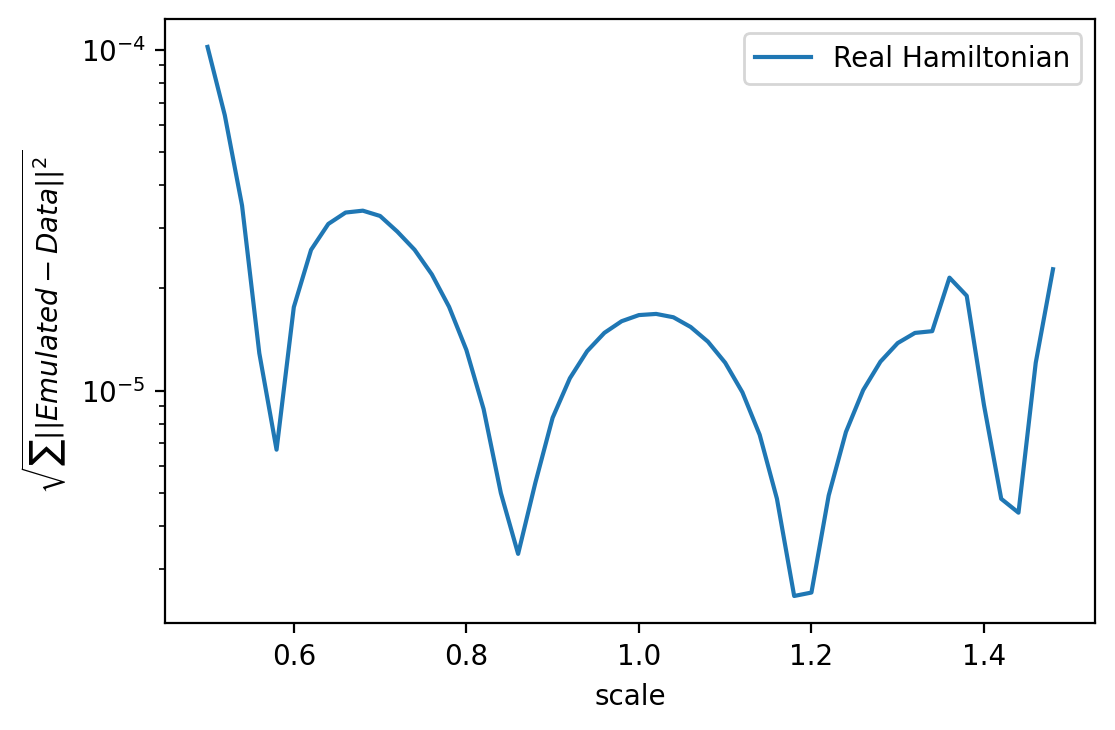

In [14]:
''' Always positive component so we can gauge '''
judgeIndex = 1367
sign = lambda p : p*np.sign(p[judgeIndex])

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
errors = []
for j in range(len(data[0])):
    prediction = hamiltonian.predict_real(emulator.axis[j])
    prediction = sign(prediction)
    errors.append(np.linalg.norm(data[:,j]-prediction))
ax.semilogy(emulator.axis,errors,label="Real Hamiltonian")
plt.xlabel("scale")
plt.ylabel(r'$\sqrt{\sum ||Emulated - Data||^2 }$')
plt.legend()
plt.show()